![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering]
* И совсем немного затронем ML
* И многое другое...   


### И самое важное, все это вы сможете сделать самостоятельно!

# import

In [1]:
# загружаем необходимые для работы библиотеки
import pandas as pd
import numpy as np
import re 
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
import matplotlib.pyplot as plt

# описываем необходимые для работы функции

# функция, преобразующая строку с названиями кухонь в понятный компьютеру список [list] названий кухонь
def clean_name(str_val):
    str_val = str_val.strip('[]') # Отбрасываем скобки.
    str_val = str_val.replace("\'",'') # Убираем кавычки '.
    str_val = str_val.split(", ") # Разбиваем строку по названиям кухонь.
    return str_val

# функция, помечающая наличие типа кухни в ресторане
def find_item(cell):
    if item in cell:
        return 1
    return 0

# функция преобразования информации из отзыва в формат даты
def review_to_date(review):
    pattern = re.compile('\'\d+\/\d+\/\d+\'?')
    dat = pattern.findall(review)
    if len(dat) >= 2:
        datetime_list = []
        for date in dat:
            date = date[1:-1]
            dt = datetime.strptime(date, '%m/%d/%Y')
            datetime_list.append(dt)
        return datetime_list
    else:
        return (dat)
    
# функция распознавания позитивности комментария    
good = ['hidden gem','enchanting','ideal','perfect','like','cozy','cosy','pleasant','cool place','paradise','recommend','wow','haven','stylish','favorite','tasty','bravo','interesting','delightful','fantastic','delicious','love','wonderful','enjoyable','good','excellent','best','clean','unique','favourite','nice','great','lovely']
neutral = ['not']
bad = ['tipical','go away','lousy','awful','useless','too expensive','nasty','rude','dirty','worse','never coming back','poor','typical','overpric','usual','worst','let down','non recommend','wait','bad']

def positive(row):
    row = row.lower()
    for i in bad:
        if i in row:
            return 1
            break
    for i in neutral:
        if i in row:
            return 2
            break        
    for i in good:
        if i in row:
            return 3
            break      
    else:
        return 2

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
29109,id_10818,Paris,['Japanese'],10820.0,4.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187147-d4582796-Reviews-Na...,d4582796
31658,id_1490,Brussels,"['Brazilian', 'South American']",1491.0,4.0,NaN,40.0,"[['very tender beef', 'Pretty good'], ['03/27/...",/Restaurant_Review-g188644-d1869696-Reviews-Sa...,d1869696
32568,id_121,Geneva,"['Mediterranean', 'French', 'European', 'Gastr...",122.0,4.0,$$$$,254.0,"[['Classy and unpretentious', 'Pricey but very...",/Restaurant_Review-g1203132-d1524369-Reviews-R...,d1524369


In [6]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [8]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [10]:
df.Reviews.fillna('[[], []]', inplace = True)


Описание датасета:

Restaurant_id — идентификационный номер ресторана / сети ресторанов;

City — город, в котором находится ресторан;

Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;

Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;

Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);

Price Range — диапазон цен в ресторане;

Number of Reviews — количество отзывов о ресторане;

Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;

URL_TA — URL страницы ресторана на TripAdvisor;

ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [11]:
# преобразуем названия столбцов для удобства обращения к ним в будущем
df.rename(columns={'Cuisine Style': 'Cuisine_Style', 'Price Range': 'Price_Range', 'Number of Reviews': 'Number_of_Reviews'}, inplace=True)
df.columns

Index(['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Price_Range',
       'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

## Очистка и обработка признаков

посмотрим велико ли количество пропусков в предоставленной нам выборке (датасете)

In [12]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))
df.info()# Считаем процент пропусков


Restaurant_id - 0.0%
City - 0.0%
Cuisine_Style - 23.0%
Ranking - 0.0%
Price_Range - 35.0%
Number_of_Reviews - 6.0%
Reviews - 0.0%
URL_TA - 0.0%
ID_TA - 0.0%
sample - 0.0%
Rating - 0.0%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine_Style        38410 non-null object
Ranking              50000 non-null float64
Price_Range          32639 non-null object
Number_of_Reviews    46800 non-null float64
Reviews              50000 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


количество пропусков в колонках стиля кухни и уровня цен настолько велико (четверть и треть данных соответственно), что имеет смысл присвоить им отдельную категорию "unknown"

In [13]:
df.Cuisine_Style = df.Cuisine_Style.fillna('unknown')
df.Price_Range = df.Price_Range.fillna('unknown')

### Number_of_Reviews

In [14]:
# посмотрим на колонку с количеством отзывов
df.Number_of_Reviews.describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number_of_Reviews, dtype: float64

видим минимальное количество отзывов равное двум и хотим посмотреть на те строки, в которых количество не указано, возможно по таким ресторанам нет отзывовНекоторые id встречаются более 1 раза, что может быть всязано с тем, что они являются сетевыми. Создадим новый признак chain: 1 - ресторан сетевой, 0 - нет.

In [15]:
# посмотрим на строки, в которых нет данных о количестве отзывов
df.Number_of_Reviews = df.Number_of_Reviews.fillna('unknown')
df[df.Number_of_Reviews == 'unknown']

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,sample,Rating
7,id_7,Budapest,unknown,2330.0,unknown,unknown,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0
25,id_25,Madrid,unknown,5828.0,unknown,unknown,"[[], []]",/Restaurant_Review-g187514-d13202032-Reviews-W...,d13202032,0,0.0
53,id_53,Prague,unknown,2095.0,unknown,unknown,"[[], []]",/Restaurant_Review-g274707-d7124128-Reviews-Ch...,d7124128,0,0.0
74,id_74,Prague,"['Cafe', 'European', 'Czech']",2052.0,$,unknown,"[[""Nova' Doba""], ['01/26/2017']]",/Restaurant_Review-g274707-d12032989-Reviews-C...,d12032989,0,0.0
81,id_81,Barcelona,"['Peruvian', 'South American']",4325.0,$$ - $$$,unknown,"[[], []]",/Restaurant_Review-g187497-d10088997-Reviews-N...,d10088997,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49965,id_5720,Rome,unknown,5722.0,unknown,unknown,"[[], []]",/Restaurant_Review-g187791-d793376-Reviews-Wes...,d793376,1,5.0
49972,id_2009,Prague,"['Cafe', 'Delicatessen', 'Healthy', 'Wine Bar'...",2012.0,$,unknown,"[['Personal expirence'], ['10/27/2017']]",/Restaurant_Review-g274707-d12981295-Reviews-M...,d12981295,1,5.0
49986,id_7274,Madrid,unknown,7279.0,unknown,unknown,"[[], []]",/Restaurant_Review-g187514-d12182212-Reviews-C...,d12182212,1,3.0
49988,id_4968,Berlin,unknown,4970.0,unknown,unknown,"[[], []]",/Restaurant_Review-g187323-d7761701-Reviews-Ar...,d7761701,1,4.0


In [16]:
"""видим, что по ресторанам с неизвестным количеством отзывов встречаются как строки, в которых отзывов нет, так и одиночные отзывы посетителей
разметим количество отзывов как 0 и 1 соответственно"""

for i in range(0,len(df)):
    string = df.Reviews[i]
    #print (df.Number_of_Reviews[i])
    #print (df.Reviews[i])
    if df.Number_of_Reviews[i] == 'unknown':
        if len(string) < 9: # строка без отзывов занимает 8 символов: [[], []]
            df.Number_of_Reviews[i] = df.Number_of_Reviews[i].replace('unknown','0')
        else:
            df.Number_of_Reviews[i] = df.Number_of_Reviews[i].replace('unknown','1')

df.Number_of_Reviews = df.Number_of_Reviews.apply(lambda x: int(x)) # возвращаем количество отзывов к числовому формату

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


# City

посмотрим на колонку с городами, в которых расположены рестораны

In [17]:
df.City.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [18]:
len(df.City.unique()) # всего таких городов 31

31

преобразуем колонку City в числовой признак dummie переменной

In [19]:
df = pd.get_dummies(df, columns = ['City'])

### Number of reviews

рассмотрим колонку с уровнем цен ресторана

In [20]:
df['Price_Range'].unique()

array(['$$ - $$$', '$$$$', '$', 'unknown'], dtype=object)

видим, что колонка содержит 4 варианта значений (неизвестно, дешёвые, средние и дорогие) у нас два варианта действий:

1) ранжировать рестораны от 1 до 3 и заменить пропуски

2) разбить данные на 4 колонки использую dummie переменные
Проверим насколько сильна корреляция между целевой переменной "рейтинг" и уровнем цен

In [21]:
#df_train.rename(columns={'Price Range': 'Price_Range'}, inplace=True)
#df_train.Price_Range = df.Price_Range.fillna('unknown')
#dftest = df_train[df_train.columns[3:5]].copy() # создадим копию датафрейма для теста гипотезы
#dftest = dftest.loc[dftest['Price_Range'] != 'unknown'] # исключим строки не содержащие необходимые для теста данные
#dftest.Price_Range = dftest.Price_Range.replace('$','1') # задаём понятные компьютеру числовые соответствия уровню цен
#dftest.Price_Range = dftest.Price_Range.replace('$$ - $$$','2')
#dftest.Price_Range = dftest.Price_Range.replace('$$$$','3')

#dftest.Price_Range = dftest.Price_Range.apply(lambda x: int(x)) # преобразуем колонку в числовой формат

#ar1 = dftest.Rating # задаём параметры для сравнения матрицы корреляции
#ar2 = dftest.Price_Range
#print(np.corrcoef(ar1,ar2))

Вывод теста: корреляция между рейтингом ресторана и уровнем цен статистически ничтожна и составила -0.0225. Следовательно люди присваивают оценку ресторану учитывая его уровень цен, и возможно люди даже более требовательны к дорогим ресторанам Для нас это значит, что мы пойдём вторым путём и разделим рестораны при помощи dummie переменных на 4 категории

преобразуем колонку Price_Range в числовой признак dummie переменной

In [22]:
df = pd.get_dummies(df, columns = ['Price_Range']) 

### Cuisine_Style

Проверим влияет ли параметр Cuisine_Style на точность определения рейтинга, возможно есть виду кухни, которые тяжело испортить чем-либо или наоборот, вызывающие низкие оценки вне зависимости от стараний рестораторов

In [23]:
# применяем функцию преобразования содержимого колонки Cuisine_Style в список
df.Cuisine_Style = df.Cuisine_Style.apply(clean_name) 

# Создадим список уникальных значений типов кухонь
Cuisines = set() 
for i in df['Cuisine_Style']:
    for j in i:
        Cuisines.add(j)

len(Cuisines) # 126 типов кухонь представлено в наборе данных (125 + unknown)

126

In [24]:
# Посмотрим как распределены типы кухонь
Cuisines_dct = {}  # создаём пустой словарь для хранения частоты встречи кухонь
for i in Cuisines:  # перебираем список кухонь
    Cuisines_dct[i] = 0 # добавляем в словарь ключ, соответствующий очередной кухне
for c in df['Cuisine_Style']:   # перебираем список кухонь
    for j in c:
        Cuisines_dct[j] += 1   # увеличиваем значение нужного ключа в словаре на 1

dftest3 = pd.DataFrame.from_dict(Cuisines_dct, columns=['Count'], orient='index')
dftest3 = dftest3[dftest3['Count'] > 30] # в целях увеличения статистической достоверности рассмотрим только типы кухонь, встречающиеся не реже заданного количества раз
dftest3.sort_values(by = ['Count'], ascending = False) 

,Count
Vegetarian Friendly,14021
European,12561
unknown,11590
Mediterranean,7820
Italian,7433
...,...
Malaysian,38
Jamaican,36
Australian,36
Croatian,33


In [25]:
# запускаем код, создающий столбцы с наименованием типа кухни
for item in dftest3.index:
    df[item] = df.Cuisine_Style.apply(find_item)
    
# заменим список типов кухонь на их количество
df.Cuisine_Style = df.Cuisine_Style.apply(len)    

df

,Restaurant_id,Cuisine_Style,Ranking,Number_of_Reviews,Reviews,URL_TA,ID_TA,sample,Rating,City_Amsterdam,...,Vegan Options,British,Pizza,Wine Bar,Portuguese,Belgian,Central European,Scandinavian,Peruvian,Italian
0,id_0,2,12963.0,4,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_1,5,106.0,97,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,...,1,0,0,0,0,0,0,1,0,0
2,id_2,1,810.0,28,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,5,1669.0,202,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
4,id_4,6,37.0,162,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,4,500.0,79,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,0,...,1,0,0,0,0,0,0,0,0,1
49996,id_6340,5,6341.0,542,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,0,...,0,0,0,0,0,0,0,0,0,0
49997,id_1649,2,1652.0,4,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,0,...,0,0,0,0,0,0,0,0,0,0
49998,id_640,5,641.0,70,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,0,...,0,0,0,0,0,0,1,0,0,0


### Restaurant_id

In [26]:
df.Restaurant_id.value_counts()

id_633      19
id_227      19
id_871      19
id_436      19
id_71       18
            ..
id_9476      1
id_12166     1
id_13319     1
id_10754     1
id_12897     1
Name: Restaurant_id, Length: 13094, dtype: int64

Мы видим что есть повторящиеся id, возможно эти рестораны сетевые.

Создадим новый признак chain: 1 - сетевой, 0 - несетевой.

In [27]:
chain_lst = list(df.Restaurant_id.value_counts()[df.Restaurant_id.value_counts() > 1].index)
df['chain'] = df[df.Restaurant_id.isin(chain_lst)].Restaurant_id.apply(lambda x: 1)
df['chain'].fillna(0, inplace=True)
df['chain'].value_counts()

1.0    46193
0.0     3807
Name: chain, dtype: int64

### Reviews

рассмотрим параметр Reviews если ресторан накручивает себе рейтинг, то он делает это именно за счёт добавления липовых отзывов, иных вариантов быть не может. Однако посмотрим на результаты.

In [28]:
df.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Значения признака представлены в виде строки, но есть четкая структура списков.

Посмотрим на содержание комментариев и попробуем категоризировать отзывы как положительные, отрицательные и нейтральные

In [29]:
df['positive'] = df.Reviews.apply(lambda x: positive(x))

In [30]:
# преобразуем колонку
df['Reviews'] = df.Reviews.dropna().apply(
    lambda x: eval(x.replace('nan', '').replace('[,', "['',")))
df['Reviews'] = df['Reviews'].dropna().apply(
    lambda x: np.nan if len(x[0]) == 0 & len(x[1]) == 0 else x)

Создадим новые признаки, reviews и date_1 date_2

In [31]:
df['date'] = df['Reviews'].dropna().apply(lambda x: x[1])
df['date_1'] = df['date'].dropna().apply(lambda x: x[1] if len(x) == 2 else np.nan)
df['date_2'] = df['date'].dropna().apply(lambda x: x[0] if len(x) > 0 else np.nan)
df.drop('date', axis=1, inplace=True)

Заменим пропуски в date_1 и date_2 на min и max дату соответственно. Максимальная разница количества дней между коментариями будет говорит о том, что отзывы практически не оставляют

In [32]:
df['date_1'] = pd.to_datetime(df['date_1'])
df['date_2'] = pd.to_datetime(df['date_2'])

df['date_1'].fillna(df['date_1'].min(), inplace=True)
df['date_2'].fillna(df['date_2'].max(), inplace=True)

Создадим признак разницы дней между последними двумя отзывами.

In [33]:
df['rewiew_days'] = abs(df['date_2'] - df['date_1']).dt.days

df['days_to_today'] = (datetime.now() - df['date_2']).dt.days
df['days_to_today']

0        1240
1        1323
2        1300
3        1322
4        1258
         ... 
49995    1312
49996    1307
49997    1720
49998    1470
49999    1997
Name: days_to_today, Length: 50000, dtype: int64

Обработаем отзывы. Создадим признак количества последних коментариев (0-2)

In [34]:
df['Reviews'] = df['Reviews'].dropna().apply(lambda x: x[0])
df['last_rewiew_counts'] = df['Reviews'].dropna().apply(
    lambda x: 2 if len(x) == 2 else 1 if len(x) == 1 else 0)
df.last_rewiew_counts.fillna(0, inplace=True)

def len_rewiews(cell):
    x = 0
    for i in cell:
        x += len(i)
    return x

df['len_rewiews'] = df['Reviews'].dropna().apply(len_rewiews)
df['len_rewiews'].fillna(0, inplace=True)

Удаляем текстовые столбцы для теста модели

In [35]:
df.drop(['Reviews', 'URL_TA', 'ID_TA', 'date_1','date_2'], inplace = True, axis = 1)

In [36]:
df

,Restaurant_id,Cuisine_Style,Ranking,Number_of_Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,...,Central European,Scandinavian,Peruvian,Italian,chain,positive,rewiew_days,days_to_today,last_rewiew_counts,len_rewiews
0,id_0,2,12963.0,4,0,0.0,0,0,0,0,...,0,0,0,0,1.0,2,3757,1240,0.0,0.0
1,id_1,5,106.0,97,0,0.0,0,0,0,0,...,0,1,0,0,1.0,3,37,1323,2.0,42.0
2,id_2,1,810.0,28,0,0.0,0,0,0,0,...,0,0,0,0,1.0,2,22,1300,2.0,30.0
3,id_3,5,1669.0,202,0,0.0,0,0,0,0,...,0,0,0,1,1.0,3,14,1322,2.0,37.0
4,id_4,6,37.0,162,0,0.0,0,0,0,0,...,0,0,0,1,1.0,3,15,1258,2.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,4,500.0,79,1,4.5,0,0,0,0,...,0,0,0,1,1.0,3,34,1312,2.0,64.0
49996,id_6340,5,6341.0,542,1,3.5,0,0,0,0,...,0,0,0,0,1.0,3,9,1307,2.0,63.0
49997,id_1649,2,1652.0,4,1,4.5,0,0,0,0,...,0,0,0,0,1.0,3,3127,1720,2.0,70.0
49998,id_640,5,641.0,70,1,4.0,0,0,0,0,...,1,0,0,0,1.0,2,23,1470,2.0,49.0


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [37]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)
test_data = test_data.drop(['Restaurant_id','Rating'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Restaurant_id','Rating'], axis=1)

# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 25% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [38]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
#X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
#y = df['Rating']

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# Создаём, обучаем и тестируем модель

In [39]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

# # Округлим предсказанные значения до степени округления целевой переменной
# y_pred = np.round(y_pred*2)/2

def rating(prediction):
        if prediction < 0.25:
            return 0
        elif 0.25 < prediction <= 0.75:
            return 0.5
        elif 0.75 < prediction <= 1.25:
            return 1
        elif 1.25 <prediction <= 1.75:
            return 1.5
        elif 1.75 < prediction <= 2.25:
            return 2
        elif 2.25 < prediction <= 2.75:
            return 2.5
        elif 2.75 < prediction <= 3.25:
            return 3
        elif 3.25 < prediction <= 3.75:
            return 3.5
        elif 3.75 < prediction <= 4.25:
            return 4
        elif 4.25 < prediction <= 4.75:
            return 4.5
        else:
            return 5
        
for i in range(y_pred.size):
        y_pred[i]=rating(y_pred[i])

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.18065


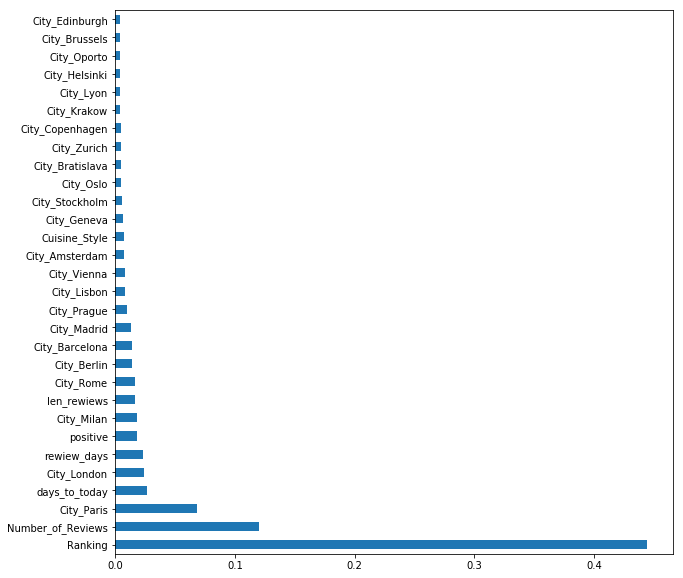

In [40]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [41]:
test_data.sample(10)

,Cuisine_Style,Ranking,Number_of_Reviews,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,...,Central European,Scandinavian,Peruvian,Italian,chain,positive,rewiew_days,days_to_today,last_rewiew_counts,len_rewiews
1731,8,6837.0,73,0,0,0,0,0,0,0,...,0,0,0,0,1.0,2,6,1295,2.0,76.0
4239,4,3838.0,10,0,0,0,0,0,0,0,...,0,0,0,1,1.0,3,1,1291,2.0,71.0
4509,1,4258.0,26,0,0,0,0,0,0,0,...,0,0,0,1,1.0,3,228,2342,2.0,28.0
5394,4,3245.0,1,1,0,0,0,0,0,0,...,0,0,0,0,1.0,2,3498,1499,1.0,44.0
7481,3,5814.0,159,0,0,0,0,0,0,0,...,0,0,0,1,1.0,2,2,1339,2.0,59.0
7074,3,256.0,106,0,0,0,0,0,0,0,...,0,0,0,0,1.0,3,241,1644,2.0,44.0
2585,4,801.0,32,0,0,0,0,0,0,0,...,0,0,0,0,1.0,3,134,1294,2.0,35.0
5242,5,238.0,82,0,0,0,0,0,0,0,...,0,0,0,0,1.0,2,22,1604,2.0,57.0
4210,3,5004.0,7,0,0,0,0,0,0,0,...,0,0,0,0,0.0,3,3535,1462,1.0,20.0
5031,1,5607.0,6,0,0,0,0,0,0,0,...,0,0,0,0,1.0,2,3757,1240,0.0,0.0


In [42]:
predict_submission = regr.predict(test_data)

In [43]:
predict_submission

array([3.025, 4.275, 4.39 , ..., 3.025, 4.485, 4.305])

In [44]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.025
1,id_1,4.275
2,id_2,4.390
3,id_3,4.355
4,id_4,4.480
5,id_5,4.355
6,id_6,2.830
7,id_7,2.855
8,id_8,3.990
9,id_9,4.545


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
